In [1]:
# initial setup
# %run "../../../common/0_notebooks_base_setup.py"


<link rel="stylesheet" href="../../../common/dhds.css">
<div class="Table">
    <div class="Row">
        <div class="Cell grey left"> <img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M6/CLASE_48_Series_de_Tiempo_1/Presentacion/img/M6_CLASE_48_portada.gif" align="center" width="70%"/></div>
        <div class="Cell right">
            <div class="div-logo"><img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/common/logo_DH.png" align="center" width=70% /></div>
            <div class="div-curso">DATA SCIENCE</div>
            <div class="div-modulo">MÓDULO 6</div>
            <div class="div-contenido">Series de Tiempo 1

</div>
        </div>
    </div>
</div>

### Agenda

---

- Series de tiempo.
   - Definición.
   - Componentes.
   - Descomposición.
---

- Modelos básicos para pronósticos.
   - Random Walk.
   - Media constante.
   - Tendencia lineal.
   - Tendencia cuadrática.
   - Tendencia con transformación logarítmica con y sin Estacionalidad mensual.
   - Media movil.
   - Single Exponential Smoothing.

<div class="div-dhds-fondo-1"> Introducción
<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M3/CLASE_21_Regresion_Lineal_Simple/Presentacion/img/M3_CLASE_21_separador.png" align="center" />

</div>

### Introducción

---
Una **serie de tiempo** es un conjunto de observaciones tomadas en *intervalos regulares* (lags), **ordenadas** por el momento en que se produjeron.

**Time series analysis** (*análisis de series de tiempo*) comprende métodos para *proyectar la evolución*, obtener *estadísticas y otras características* de una variable a lo largo del tiempo.

**Time series forecasting** (*Pronóstico de series de tiempo*) es el uso de los modelos para predecir futuros valores.

La serie de tiempo se proyecta como una *variable* (eje y) en *función del tiempo* (eje x). 

<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M6/CLASE_48_Series_de_Tiempo_1/Presentacion/img/M6_CLASE_48_001_serie.JPG" alt="serie" width=50% height=35% align="center"/>

Existen muchos ejemplos de datos que se pueden expresar como series de tiempo:

- Variables macroeconómicas (PBI, inflación, reservas del BCRA...).

- Movimientos comerciales (ventas, compras, pagos a proveedores...).

- Datos de producción (horas de horno, material consumido...).

- Consumo energético.

- Activos financieros.

- Variables sociales (mortalidad infantil, pobreza...).

### Componentes de una serie de tiempo

---

Podemos encontrar en una serie de tiempo **cuatro componentes**:

- **Tendencia** (Trend): es el componente *permanente*, el efecto persistente en el tiempo.

- **Estacionalidad** (Seasonality): es un patrón estacional que se *repite con regularidad*. 

- **Componente aleatoria** (Residual - Remainder): son shocks que no presentan un efecto duradero. Se los define también como ruido o movimientos random.

- **Ciclos** (Cycle): otro tipo de dinámica no capturada por la tendencia o estacionalidad. 

<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M6/CLASE_48_Series_de_Tiempo_1/Presentacion/img/M6_CLASE_48_002_componentes.jpg" alt="componentes" width=50% height=30% align="center"/>

El módulo `statsmodels.api`, método `tsa.seasonal_decompose` genera gráficos con: *la serie de tiempo, la tendencia, la estacionalidad y el componente aleatorio*.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#import matplotlib as mpl
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel("../Data/Supertienda.xls")
mobiliario = df.loc[df['Categoria'] == 'Mobiliario']

In [4]:
mobiliariogb = mobiliario.groupby('Fecha_pedido')['Ventas'].sum().reset_index()
mobiliariogb = mobiliariogb.set_index('Fecha_pedido')
y = mobiliariogb['Ventas'].resample('MS').mean()

<Figure size 1152x720 with 0 Axes>

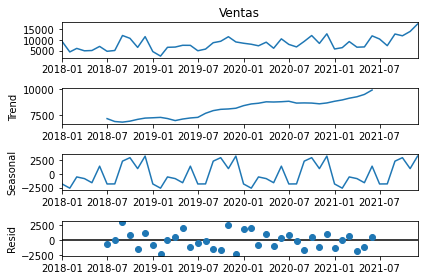

In [5]:
import statsmodels.api as sm
plt.figure(figsize=(16,10))
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

### Descomposición de una serie de tiempo

---

Podemos pensar en descomponer una serie de tiempo en sus componentes. Básicamente, existen dos formas:

- **Descomposición aditiva**:$$ y_t = T_t + S_t + C_t + \varepsilon_t. $$

donde T es la tendencia, S es la estacionalidad, C es el ciclo y $ \varepsilon $ es el error aleatorio.

- **Descomposición multiplicativa**: $$ y_t = T_t * S_t * C_t * \varepsilon_t. $$

- La descomposición aditiva es útil cuando la variación estacional se *mantiene relativamente constante* (lineal).

  O dicho de otra forma, la altura de sus picos es constante. 

- La descomposición multiplicativa es útil cuando la *tendencia crece* y la *amplitud de la variación estacional aumenta* (exponencial).

  O por el contrario, cuando la tendencia y la amplitud decrecen.

<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M6/CLASE_48_Series_de_Tiempo_1/Presentacion/img/M6_CLASE_48_003_descomposicion.png" alt="descomposicion" width=80% height=50% align="center"/>


<div class="div-dhds-fondo-1"> Modelos básicos para pronósticos
<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M3/CLASE_21_Regresion_Lineal_Simple/Presentacion/img/M3_CLASE_21_separador.png" align="center" />

</div>

### Introducción

---
Estudiamos modelos aplicados a los componentes de las series para generar predicciones.

Para cada modelo:

- Lo *definimos*. 

- Lo *ajustamos* a los datos de train.

- Lo *evaluamos* usado RMSE sobre los datos de test.

- Lo *comparamos* con otros modelos.

Recordemos que el **error cuadrático medio raíz (RMSE)** compara los valores predichos con los valores observados.

$${RMSE} = \sqrt{{\frac {1}{n}} \sum _{i=1}^{n}(y_{i}-\hat{y_{i}})^2}$$

In [6]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

<div class="div-dhds-fondo-1">  Dataset
<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M3/CLASE_21_Regresion_Lineal_Simple/Presentacion/img/M3_CLASE_21_separador.png" align="center" />

</div>

### Dataset

---

Vamos a usar datos de ventas de una empresa multinacional en varios paises, entre los años 2018 y 2021.

Consideramos las ventas de la categoría Muebles.

In [7]:
df = pd.read_excel("../Data/Supertienda.xls")
mobiliario = df.loc[df['Categoria'] == 'Mobiliario']
mobiliario.head(2)

,ID,ID_pedido,Fecha_pedido,Fecha_envio,Forma_envio,ID_cliente,Nombre_cliente,Segmento,Ciudad,Estado,Pais,Region,ID_producto,Categoria,Subcategoria,Nombre_producto,Ventas,Cantidad,Descuento,Ganancia
1,5919,MX-2021-113922,2021-10-08,2021-10-11,Rápido,BS-12130,Benjamín Saavedra,Cliente,Rio Branco,Acre,Brasil,Sur,MOB-LI-10000647,Mobiliario,Librerías,"Dania Conjunto de estantes, Metal",2250.8,2,0.0,922.8
3,9013,MX-2019-163888,2019-06-14,2019-06-18,Estándar,AT-10090,Alejandro Trejo,Cliente,Rio Branco,Acre,Brasil,Sur,MOB-MO-10002100,Mobiliario,Mobiliario,"Tenex Bandeja apiladora, Negro",504.6,3,0.0,95.4


Mensualizamos las ventas por fecha de pedido.

Primero agrupamos las ventas por el atributo 'Fecha_pedido'. Y *creamos un índice sobre el atributo* para indicar la fecha que se usa en la serie de tiempo.

In [8]:
mobiliariogb = mobiliario.groupby('Fecha_pedido')['Ventas'].sum().reset_index()
mobiliariogb = mobiliariogb.set_index('Fecha_pedido')

La función `resample` de Pandas, permite hacer *downsampling*, llevar la serie a un espacio de tiempo más amplio. 

En nuestro caso, pasamos de días a meses; `MS` indica "a comienzo de mes".

Y con la función `mean()` agrupamos todas las ventas del mes y le calculamos el promedio.

In [9]:
df_ventas = mobiliariogb['Ventas'].resample('MS').mean().to_frame(); df_ventas.head(2)

,Ventas
Fecha_pedido,
2018-01-01,9379.808
2018-02-01,4405.700


<Figure size 288x216 with 0 Axes>

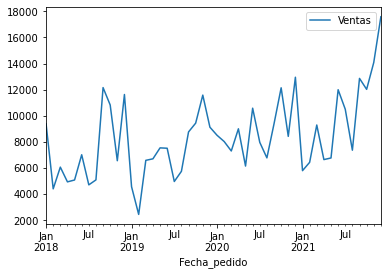

In [10]:
plt.figure(figsize=(4,3)); df_ventas.plot(); plt.show()

### Dataset

---
Dividimos el dataset en train y test. Al ser una serie de tiempo, tenemos que poner *`shuffle=False`* (que no mezcle las observaciones), creando una continuidad entre los sets de entrenamiento y de testeo.

In [11]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_ventas, test_size=12, random_state=42, shuffle=False)

Para train considera los primeros tres años, y para test el último, 2021.

In [12]:
# Vemos los últimos datos del set de entrenamiento:
df_train.tail(2)

,Ventas
Fecha_pedido,
2020-11-01,8424.513846
2020-12-01,12952.494615


In [13]:
# Vemos los primeros datos del set de testeo:
df_test.head(2)

,Ventas
Fecha_pedido,
2021-01-01,5798.076667
2021-02-01,6435.745455


<div class="div-dhds-fondo-1">  Random Walk
<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M3/CLASE_21_Regresion_Lineal_Simple/Presentacion/img/M3_CLASE_21_separador.png" align="center" />

</div>

### Definición

---

Decimos que un proceso $ {Y_t} $ es **random walk** (sigue una trayectoria al azar) si:

$$ \ {Y_t} = Y_ {t-1} + \varepsilon,  $$
   donde $\varepsilon$ es **ruido blanco** (White Noise). 

El *ruido blanco* es la parte de la serie que no se puede predecir a partir de la evidencia.

Si el modelo de *random walk* sigue a la tendencia, la representamos con una constante $d$, llamada **drift** (deriva). 

Se genera un modelo **random walk with drift** (con deriva):

$$ \ {Y_t} = Y_ {t-1} + d + \varepsilon $$


- La serie de White Noise $ \varepsilon_t $ cumple con:

   - Media (μ) = 0 y la varianza constante. Se puede escribir como $ WN(0,σ²)$ .
   
   - Es completamente random. Por eso se lo llama ruido.
   
   - Son observaciones independientes identicamente distribuidas (i.i.d.).
   
   - Tienen cero correlación entre ellas.
   
Si las observaciones siguen una distribución normal, se lo llama Gaussian White Noise Gaussiano. 

### Predicción

---

El caso más simple es suponer que el valor de la serie Yₜ se predice como el valor previo Yₜ₋₁, es decir, que tendremos valor de cambio cero.

Se llama *pronóstico ingenuo* (naive).

Un ejemplo de la vida real puede ser la estimación de los valores de las acciones.

Vamos a realizar este modelo.

Generamos el desplazamiento de nuestro target en el set de entrenamiento (lag=1):

In [14]:
df_train["VentasShift1"] = df_train.Ventas.shift()

# La primera observación nos va a quedar en nan, la reemplazamos por el valor siguente:
df_train["VentasShift1"].fillna(method='bfill', inplace=True)
df_train.head(3)

,Ventas,VentasShift1
Fecha_pedido,,
2018-01-01,9379.808,9379.808
2018-02-01,4405.700,9379.808
2018-03-01,6068.580,4405.700


Generamos el desplazamiento en el set de test (lag=1):

In [15]:
df_test["VentasShift1"] = df_test.Ventas.shift()

df_test["VentasShift1"].fillna(method='bfill', inplace=True)
df_test.head(3)

,Ventas,VentasShift1
Fecha_pedido,,
2021-01-01,5798.076667,5798.076667
2021-02-01,6435.745455,5798.076667
2021-03-01,9293.771000,6435.745455


Definimos como *random walk* al desplazamiento en un valor (shift=1).

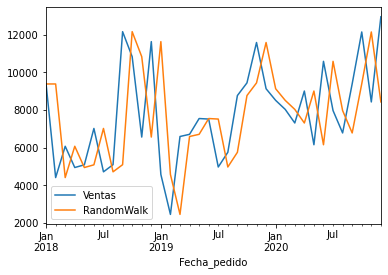

In [16]:
df_train["RandomWalk"] = df_train.VentasShift1
df_train.plot(kind="line", y = ["Ventas", "RandomWalk"]);

La predicción sobre test es simplemente la última observación registrada en train. 

In [17]:
df_test["RandomWalk"] = pd.Series(df_train["Ventas"][-1], index=df_test.index)

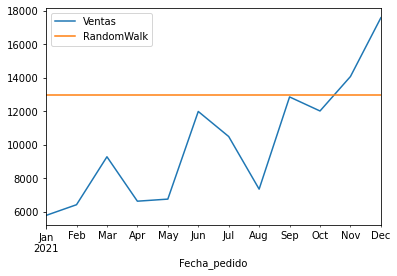

In [18]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_test.plot(kind="line", y = ["Ventas", "RandomWalk"]);

In [19]:
# Calculamos el RMSE y almacenamos los resultados
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results.loc[0, "Model"] = "Random Walk"
df_Results.loc[0, "RMSE"] = RMSE(df_test.RandomWalk, df_test.Ventas)
df_Results

,Model,RMSE
0,Random Walk,4534.835179


<div class="div-dhds-fondo-1">  Media Constante
<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M3/CLASE_21_Regresion_Lineal_Simple/Presentacion/img/M3_CLASE_21_separador.png" align="center" />

</div>

### Definición

---

La **media constante** es el modelo más básico e ingenuo de todos. 

Consiste simplemente en tomar *la media del dataset de train* y usarlo para predecir. 

In [20]:
model_mean_pred = df_train['Ventas'].mean()
model_mean_pred

7780.3312246743835

La media se aplica tanto a train como a test. 

In [21]:
df_train_mc = df_train.copy()
df_train_mc['Mean'] = model_mean_pred

df_test_mc = df_test.copy()
df_test_mc['Mean'] = model_mean_pred

Visualmente ya se observa que el método no predice correctamente. 

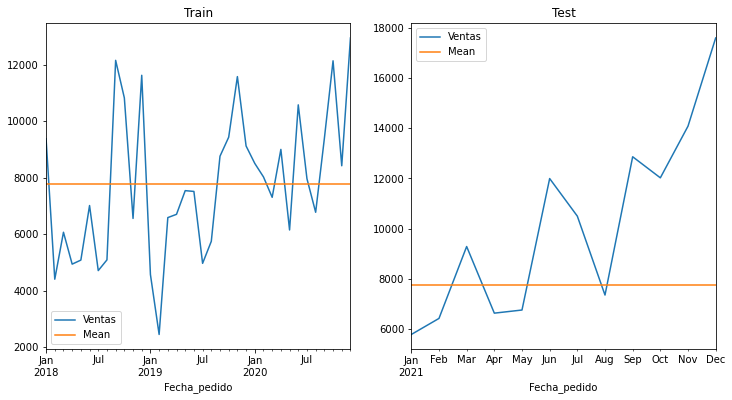

In [22]:
fig, axes = plt.subplots(1, 2,figsize=(12,6))
df_train_mc.plot(ax=axes[0], y = ["Ventas","Mean"],title='Train')
df_test_mc.plot(ax=axes[1],y = ["Ventas","Mean"], title='Test')
plt.show()

Calculamos la performance con RMSE y la guardamos para comparar con otros modelos.

In [23]:
model_RMSE = RMSE(df_test_mc.Mean, df_test_mc.Ventas)

In [24]:
df_Results.loc[1, "Model"] = "Mean"
df_Results.loc[1, "RMSE"] = model_RMSE
df_Results.head()

,Model,RMSE
0,Random Walk,4534.835179
1,Mean,4236.112012


<div class="div-dhds-fondo-1">  Tendencia Lineal
<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M3/CLASE_21_Regresion_Lineal_Simple/Presentacion/img/M3_CLASE_21_separador.png" align="center" />

</div>

### Definición

---

Recordemos que el componente de la serie **tendencia** corresponde a la **evolución de largo plazo**. 

Podemos modelar la tendencia de diferentes maneras, de acuerdo a su dinámica. 

- La **tendencia lineal** representa una recta para predecir.

  $$ T_t = \beta_0 + \beta_1 TIME_t + \varepsilon_t. $$

Donde *TIME*, llamada “dummy de tiempo”, es una secuencia que representa al tiempo.

In [25]:
df_ventas["timeIndex"] = pd.Series(np.arange(len(df_ventas['Ventas'])), index=df_ventas.index)
df_ventas.timeIndex.head(3)

Fecha_pedido
2018-01-01    0
2018-02-01    1
2018-03-01    2
Freq: MS, Name: timeIndex, dtype: int32

Volvemos a hacer los datasets de train y test con la nueva variable.

In [26]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_ventas, test_size=12, random_state=42, shuffle=False)

### Predicción

---
Para generar la recta, usamos un modelo de *regresión lineal* entre "Ventas" y "timeIndex". 

El módulo `statmodels` nos permite ajustar modelos con su API, usando fórmulas estilo R.

La sentencia:
   `smf.ols(formula='Ventas ~ timeIndex', data = df_train).fit()`

Nos indica que haremos regresión lineal (`ols`), con dos variables (`formula`).
    
Para mas detalles,  [ver aquí](http://www.statsmodels.org/dev/examples/notebooks/generated/formulas.html).

In [27]:
import statsmodels.api as sm
sm.OLS.from_formula

<bound method Model.from_formula of <class 'statsmodels.regression.linear_model.OLS'>>

In [28]:
import statsmodels.formula.api as smf
model_linear = smf.ols(formula='Ventas ~ timeIndex', data = df_train).fit()

Generamos las predicciones del modelo sobre *train y test*.

In [29]:
df_train["LinearTrend"] = model_linear.predict(df_train.timeIndex)
df_test["LinearTrend"] = model_linear.predict(df_test.timeIndex)

Visualmente observamos que la recta ajusta mejor que la media constante. 

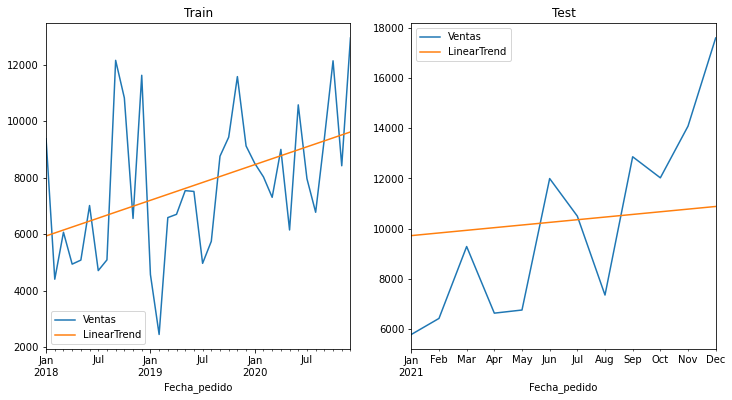

In [30]:
fig, axes = plt.subplots(1, 2,figsize=(12,6))
df_train.plot(kind = "line", y = ["Ventas","LinearTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["Ventas","LinearTrend"],ax=axes[1],title='Test');
plt.show()

Calculamos la performance con RMSE. Y confirmamos analíticamente que es mejor que Mean.

In [31]:
model_RMSE = RMSE(df_test.LinearTrend, df_test.Ventas)

In [32]:
df_Results.loc[2, "Model"] = "LinearTrend"
df_Results.loc[2, "RMSE"] = model_RMSE
df_Results.head()

,Model,RMSE
0,Random Walk,4534.835179
1,Mean,4236.112012
2,LinearTrend,3238.586751


`statmodels` nos permite ver los resultados de la regresión lineal.

In [33]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Ventas   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     7.815
Date:                Thu, 02 Jun 2022   Prob (F-statistic):            0.00846
Time:                        17:23:07   Log-Likelihood:                -329.45
No. Observations:                  36   AIC:                             662.9
Df Residuals:                      34   BIC:                             666.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5938.0319    766.370      7.748      0.000    4380.581    7495.482
timeIndex    105.2742     37.657      2.796      0.008      28.745     181.803
==============================================================================
Omnibus:                        2.097   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.350   Jarque-Bera (JB):                1.695
Skew:                           0.526   Prob(JB):                        0.429
Kurtosis:                       2.851   Cond. No.                         39.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div class="div-dhds-fondo-1"> Tendencia cuadrática
<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M5/CLASE_34_CART/Presentacion/img/M5_CLASE_34_separador.png" align="center" />

</div>

### Definición

---
Si la tendencia presenta una dinámica no lineal, podemos incluir un **término cuadrático** al modelo. 

Lo obtenemos simplemente elevando al cuadrado a la dummy de tiempo:

$$ T_t = \beta_0 + \beta_1 TIME_t + \beta_2 TIME^{2}_t +\varepsilon_t. $$

In [34]:
df_ventas["timeIndex_sq"] = df_ventas["timeIndex"]**2
df_ventas.timeIndex_sq.head(3)

Fecha_pedido
2018-01-01    0
2018-02-01    1
2018-03-01    4
Freq: MS, Name: timeIndex_sq, dtype: int32

Volvemos a hacer los datasets de train y test con la nueva variable.

In [35]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_ventas, test_size=12, random_state=42, shuffle=False)

### Predicción

---
En este modelo, incorporamos el valor cuadrático a la fórmula.

In [36]:
import statsmodels.formula.api as smf
model_quadratic = smf.ols('Ventas ~ timeIndex + timeIndex_sq', data = df_train).fit()

Generamos las predicciones del modelo sobre *train y test*.

In [37]:
df_train["QuadraticTrend"] = model_quadratic.predict(df_train[["timeIndex","timeIndex_sq"]])
df_test["QuadraticTrend"] = model_quadratic.predict(df_test[["timeIndex","timeIndex_sq"]])

Observamos visualmente las predicciones.

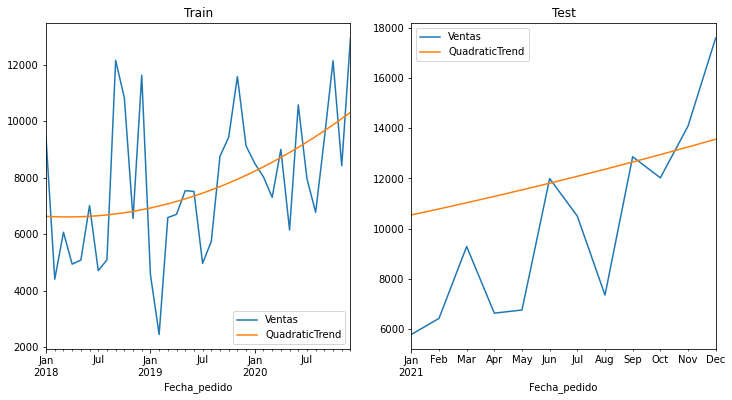

In [38]:
fig, axes = plt.subplots(1, 2,figsize=(12,6))
df_train.plot(kind = "line", y = ["Ventas","QuadraticTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["Ventas","QuadraticTrend"],ax=axes[1],title='Test');
plt.show()

Calculamos la performance con RMSE. En este dataset, sigue ajustando mejor la tendencia lineal.

In [39]:
model_RMSE = RMSE(df_test.QuadraticTrend, df_test.Ventas)

In [40]:
df_Results.loc[3, "Model"] = "QuadraticTrend"
df_Results.loc[3, "RMSE"] = model_RMSE
df_Results.head()

,Model,RMSE
0,Random Walk,4534.835179
1,Mean,4236.112012
2,LinearTrend,3238.586751
3,QuadraticTrend,3344.490376


In [41]:
model_quadratic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Ventas   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     4.248
Date:                Thu, 02 Jun 2022   Prob (F-statistic):             0.0228
Time:                        17:23:09   Log-Likelihood:                -329.05
No. Observations:                  36   AIC:                             664.1
Df Residuals:                      33   BIC:                             668.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6633.3127   1115.542      5.946      0.000    4363.726    8902.899
timeIndex      -17.4224    147.486     -0.118      0.907    -317.485     282.640
timeIndex_sq     3.5056      4.073      0.861      0.396      -4.781      11.792
==============================================================================
Omnibus:                        2.463   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.292   Jarque-Bera (JB):                1.996
Skew:                           0.573   Prob(JB):                        0.369
Kurtosis:                       2.871   Cond. No.                     1.60e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<div class="div-dhds-fondo-1"> Tendencia con transformación logarítmica
<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M5/CLASE_34_CART/Presentacion/img/M5_CLASE_34_separador.png" align="center" />

</div>

### Definición

---
En algunos casos, la varianza de la serie aumenta con el paso del tiempo. 

Hacer una **transformación logarítmica** de la serie puede ayudar a estabilizar la varianza.

- Generamos el modelo *sobre el logaritmo de las ventas*, y sus predicciones.

- *Volvemos a transformar* las predicciones a un valor de ventas, con una función exponencial.

- Este último valor será la *predicción final*, el cual evaluamos.

Trasformamos en logaritmo las ventas y las graficamos.

In [42]:
df_train['log_Ventas'] = np.log(df_train['Ventas'])
df_test['log_Ventas'] = np.log(df_test['Ventas'])

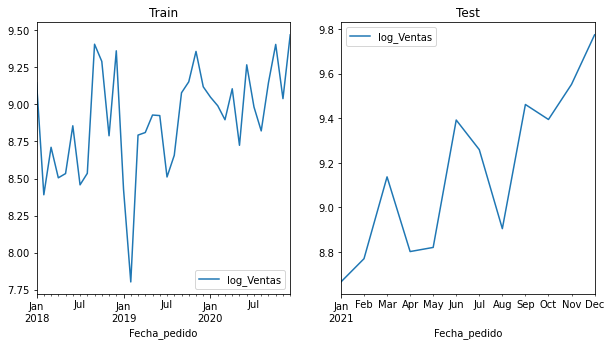

In [43]:
fig, axes = plt.subplots(1, 2,figsize=(10,5))
df_train.plot(kind = "line", y = ["log_Ventas"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["log_Ventas"],ax=axes[1],title='Test');
plt.show()

### Predicción

---
Generamos el modelo de regresión lineal usando el logaritmo de las ventas.

In [44]:
import statsmodels.formula.api as smf
model_log = smf.ols('log_Ventas ~ timeIndex ', data = df_train).fit()

Y las predicciones del modelo sobre *train y test*.

In [45]:
df_train["LogTrend"] = model_log.predict(df_train[["timeIndex"]])
df_test["LogTrend"] = model_log.predict(df_test[["timeIndex"]])

Recuperamos el valor predicho de la venta aplicando la función exponencial sobre las predicciones.

In [46]:
df_train['back_LogTrend'] = np.exp(df_train['LogTrend'])
df_test['back_LogTrend'] = np.exp(df_test['LogTrend'])

Observamos visualmente las ventas predichas vs el valor real.

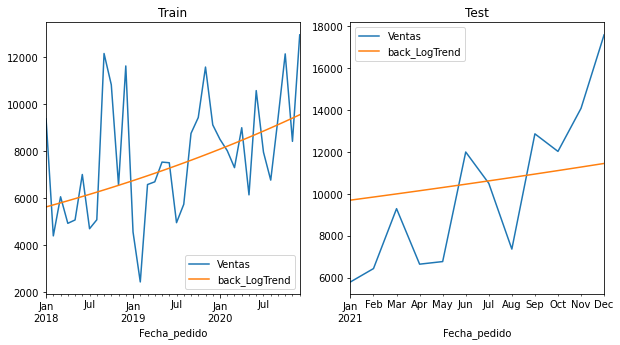

In [47]:
fig, axes = plt.subplots(1, 2,figsize=(10,5))
df_train.plot(kind = "line", y = ["Ventas","back_LogTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["Ventas","back_LogTrend"],ax=axes[1],title='Test');
plt.show()

Calculamos la performance con RMSE. El modelo ajusta mejor que los anteriores para este dataset.

In [48]:
model_RMSE = RMSE(df_test.back_LogTrend, df_test.Ventas)

In [49]:
df_Results.loc[4, "Model"] = "back_LogTrend"
df_Results.loc[4, "RMSE"] = model_RMSE
df_Results.head()

,Model,RMSE
0,Random Walk,4534.835179
1,Mean,4236.112012
2,LinearTrend,3238.586751
3,QuadraticTrend,3344.490376
4,back_LogTrend,3111.252518


In [50]:
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_Ventas   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     8.227
Date:                Thu, 02 Jun 2022   Prob (F-statistic):            0.00704
Time:                        17:23:11   Log-Likelihood:                -9.8763
No. Observations:                  36   AIC:                             23.75
Df Residuals:                      34   BIC:                             26.92
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.6372      0.107     80.754      0.000       8.420       8.855
timeIndex      0.0151      0.005      2.868      0.007       0.004       0.026
==============================================================================
Omnibus:                        5.314   Durbin-Watson:                   1.690
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                4.570
Skew:                          -0.440   Prob(JB):                        0.102
Kurtosis:                       4.507   Cond. No.                         39.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div class="div-dhds-fondo-1"> Transformación logarítmica <br/>  + estacionalidad mensual
<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M5/CLASE_34_CART/Presentacion/img/M5_CLASE_34_separador.png" align="center" />

</div>

### Definición

---

Recordemos que la  **estacionalidad** (Seasonality) es un patrón estacional que se *repite con regularidad*. 

Podemos modelar la estacionalidad utilizando variables dummy. En el siguiente ejemplo modelamos una estacionalidad trimestral:

<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M6/CLASE_48_Series_de_Tiempo_1/Presentacion/img/M6_CLASE_48_004_estacionalidad.png" alt="estacionalidad" width=50% height=30% align="center"/>

$$ S_t = \sum_{i=1}^{s} \gamma_iD_it  + \varepsilon_t. $$

Se pueden crear otros tipos de dummies, por ejemplo por días de vacaciones/feriados, etc.

Establecemos variables dummy para los meses de la fecha de pedido de las ventas.

In [51]:
# Creamos columna con el mes
df_train['month'] = [d.strftime('%b') for d in df_train.index]
df_test['month']  = [d.strftime('%b') for d in df_test.index]

In [52]:
# Creamos las variables dummies de mes
dummies_mes_train = pd.get_dummies(df_train['month'])
dummies_mes_test = pd.get_dummies(df_test['month'])

In [53]:
# Hacemos el join entre el DataFrame con la serie de tiempo y las dummies
df_train = df_train.join(dummies_mes_train)
df_test = df_test.join(dummies_mes_test)

In [54]:
df_train.head(4)

,Ventas,timeIndex,timeIndex_sq,QuadraticTrend,log_Ventas,LogTrend,back_LogTrend,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Fecha_pedido,,,,,,,,,,,,,,,,,,,,
2018-01-01,9379.808000,0,0,6633.312679,9.146315,8.637246,5637.782467,Jan,0,0,0,0,1,0,0,0,0,0,0,0
2018-02-01,4405.700000,1,1,6619.395937,8.390654,8.652321,5723.414742,Feb,0,0,0,1,0,0,0,0,0,0,0,0
2018-03-01,6068.580000,2,4,6612.490429,8.710880,8.667396,5810.347686,Mar,0,0,0,0,0,0,0,1,0,0,0,0
2018-04-01,4939.484286,3,9,6612.596156,8.505016,8.682470,5898.601053,Apr,1,0,0,0,0,0,0,0,0,0,0,0


### Predicción

---
Generamos el modelo de regresión lineal como en el caso anterior, agregando al logaritmo de las ventas, la estacionalidad (las variables dummies de mes).

In [55]:
model_log_est = smf.ols('log_Ventas ~ timeIndex + Apr + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep',\
                          data = df_train).fit()

Y las predicciones del modelo sobre *train y test*.

In [56]:
df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex","Apr","Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May","Nov", "Oct", "Sep"]])

df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex","Apr","Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May","Nov", "Oct", "Sep"]])

Recuperamos el valor predicho de la venta aplicando la función exponencial sobre las predicciones.

In [57]:
df_train['back_LogEstTrend'] = np.exp(df_train['model_log_est'])
df_test['back_LogEstTrend'] = np.exp(df_test['model_log_est'])

Observamos visualmente las ventas predichas vs el valor real.

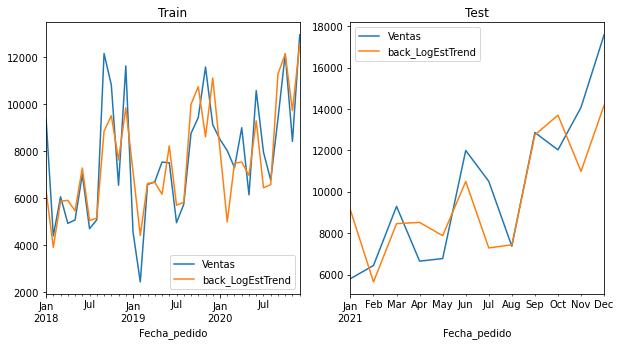

In [58]:
fig, axes = plt.subplots(1, 2,figsize=(10,5))
df_train.plot(kind = "line", y = ["Ventas","back_LogEstTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["Ventas","back_LogEstTrend"],ax=axes[1],title='Test');
plt.show()

Calculamos la performance con RMSE. El modelo ajusta mucho mejor que todos los anteriores.

In [59]:
model_RMSE = RMSE(df_test.back_LogEstTrend, df_test.Ventas)

In [60]:
df_Results.loc[5, "Model"] = "back_LogEstTrend"
df_Results.loc[5, "RMSE"] = model_RMSE
df_Results.head()

,Model,RMSE
0,Random Walk,4534.835179
1,Mean,4236.112012
2,LinearTrend,3238.586751
3,QuadraticTrend,3344.490376
4,back_LogTrend,3111.252518


In [61]:
model_log_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_Ventas   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     3.669
Date:                Thu, 02 Jun 2022   Prob (F-statistic):            0.00361
Time:                        17:23:14   Log-Likelihood:                 5.4746
No. Observations:                  36   AIC:                             15.05
Df Residuals:                      23   BIC:                             35.64
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0528      0.082     98.343      0.000       7.883       8.222
timeIndex      0.0101      0.004      2.289      0.032       0.001       0.019
Apr            0.6023      0.144      4.187      0.000       0.305       0.900
Aug            0.4258      0.144      2.951      0.007       0.127       0.724
Dec            1.0307      0.147      7.015      0.000       0.727       1.335
Feb            0.2103      0.144      1.456      0.159      -0.088       0.509
Jan            0.6998      0.145      4.828      0.000       0.400       1.000
Jul            0.4153      0.144      2.884      0.008       0.117       0.713
Jun            0.7909      0.144      5.499      0.000       0.493       1.088
Mar            0.6056      0.144      4.203      0.000       0.308       0.904
May            0.5139      0.144      3.575      0.002       0.217       0.811
Nov            0.7860      0.146      5.381      0.000       0.484       1.088
Oct            1.0169      0.145      6.996      0.000       0.716       1.318
Sep            0.9551      0.145      6.597      0.000       0.656       1.255
==============================================================================
Omnibus:                        2.851   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.240   Jarque-Bera (JB):                1.754
Skew:                          -0.231   Prob(JB):                        0.416
Kurtosis:                       3.978   Cond. No.                     4.82e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.44e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<div class="div-dhds-fondo-1"> Media Movil
<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M5/CLASE_34_CART/Presentacion/img/M5_CLASE_34_separador.png" align="center" />

</div>

### Definición

---
**Media movil** (Moving Average o Rolling Mean) es un *promedio* de los valores de una serie temporal *para un período de tiempo determinado* (la ventana de estimación).

El tamaño de la ventana de estimación $M$ es la cantidad de observaciones usadas para estimar.

Veamos el tipo de media movil llamado **media móvil simple** (Simple Moving Average).

que se expresa:
$$ {SMA_t} =\frac{1}{M}. (x_{t} + x_{t-1} + x_{t-2} + ... x_{M-(t-1)})$$
        donde el valor para el tiempo $t$, es un promedio de los M valores reales previos.

Es un *indicador de tendencia* ya que produce un **suavizado** sobre la serie temporal.

No la vamos a usar para predecir, pero puede ser útil como método de preprocesamiento de la serie.

Veamos la diferencia entre casos diarios y la media movil semanal de casos de covid-19.

<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M6/CLASE_48_Series_de_Tiempo_1/Presentacion/img/M6_CLASE_48_005_media_movil.JPG" alt="estacionalidad" width=80% height=50% align="center"/>

### Ejemplo

---
La forma más fácil para calcular **SMA** es usando el método de Pandas `Series.rolling`.

Las primeras filas contienen valores nulos, pues recién después de M observaciones se puede calcular el promedio. Pero usando el argumento `min_periods=1` podemos resolverlo.

<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M6/CLASE_48_Series_de_Tiempo_1/Presentacion/img/M6_CLASE_48_006_media_movil.png" alt="media_movil" width=70% height=25% align="center"/>

Observemos que a mayor ventana, más suave la serie calculada.

In [62]:
df_ventas["sma_5"] = df_ventas.Ventas.rolling(5,min_periods=1).mean()
df_ventas["sma_15"] = df_ventas.Ventas.rolling(15,min_periods=1).mean()

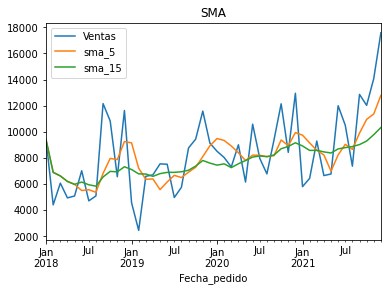

In [63]:
df_ventas.plot(kind = "line", y = ["Ventas","sma_5","sma_15"],title='SMA');

<div class="div-dhds-fondo-1"> Single Exponential Smoothing
<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M5/CLASE_34_CART/Presentacion/img/M5_CLASE_34_separador.png" align="center" />

</div>

### Definición

---
Recién vimos con *Media movil*, que los métodos de suavizado son *promedios ponderados* de observaciones pasadas. 

En el caso de **suavizamiento exponencial simple**, los pesos siguen una caída exponencial; le da más peso a las observaciones recientes y menos peso a las antiguas. 

Podemos expresarlo como:

$$ \widehat{y_t} =\alpha . y_{t-1}  + (1 - \alpha ) . \widehat{y}_{t -1} $$

Donde $\widehat{y_t}$ es el valor predicho para el tiempo $t$, que es un promedio ponderado entre el valor previo predicho $\widehat{y}_{t -1}$ y el valor actual $y_{t-1}$.

$\alpha$  se conoce como **smoothing parameter**; toma valores entre 0 y 1. 

Este método es adecuado para pronosticar datos *sin una tendencia ni un patrón estacional claro*.

Viendo la expresión:

$$ \widehat{y_t} =\alpha . y_{t-1}  + (1 - \alpha ) . \widehat{y}_{t -1} $$

- Si $\alpha$ es igual a 1, todas las predicciones *son iguales al último valor observado*. Se le llama un **método ingenuo (naive)**.

- Por otro lado, si consideramos la **media constante**, todas las predicciones *son iguales al promedio de los valores observados*.

En general se trabaja entre estos dos extremos. La expresión generalizada de **Single Exponential Smoothing**:

$$ \widehat{y_t} =\alpha . y_{t-1}  + \alpha . (1 - \alpha ) . y_{t-2}  + \alpha . (1 - \alpha )^2. y_{t-3} ...$$

Muestra que el peso de las observaciones **decrece en forma exponencial** a medida que son más antiguas.

Y $\alpha$ nos indica *el ratio de caída*. Más cerca de uno, decae más rápido.

### Predicción

---
Generamos tres modelos variando el  **smoothing factor $\alpha$** (0.3, 0.5 y 0.8).

In [64]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model_exp_smoothing_3 = SimpleExpSmoothing(df_train.Ventas).fit(smoothing_level=0.3,optimized=False)
model_exp_smoothing_5 = SimpleExpSmoothing(df_train.Ventas).fit(smoothing_level=0.5,optimized=False)
model_exp_smoothing_8 = SimpleExpSmoothing(df_train.Ventas).fit(smoothing_level=0.8,optimized=False)

Vemos los resultados sobre los datos de train.

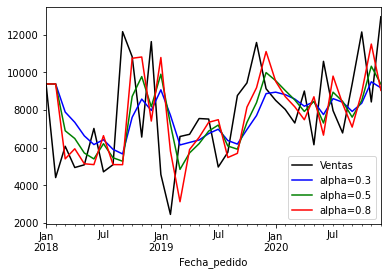

In [65]:
df_train.plot(kind = "line", y = "Ventas",color='black')
model_exp_smoothing_3.fittedvalues.plot(label="alpha=0.3",color='b');
model_exp_smoothing_5.fittedvalues.plot(label="alpha=0.5",color='g');
model_exp_smoothing_8.fittedvalues.plot(label="alpha=0.8",color='r');
plt.legend();

Hacemos las predicciones del modelo sobre *test*.

In [66]:
df_test["Simple_Smoothing_3"] = model_exp_smoothing_3.forecast(len(df_test))
df_test["Simple_Smoothing_5"] = model_exp_smoothing_5.forecast(len(df_test))
df_test["Simple_Smoothing_8"] = model_exp_smoothing_8.forecast(len(df_test))

El modelo con  $\alpha$ = 0.3 es el que mejor predice.

In [67]:
model_RMSE_3 = RMSE(df_test["Simple_Smoothing_3"], df_test.Ventas)
model_RMSE_5 = RMSE(df_test["Simple_Smoothing_5"], df_test.Ventas)
model_RMSE_8 = RMSE(df_test["Simple_Smoothing_8"], df_test.Ventas)

In [68]:
# Calculamos el RMSE y almacenamos los resultados
df_Results.loc[6, "Model"] = "Simple Smoothing a=0.3"; df_Results.loc[6, "RMSE"] = model_RMSE_3
df_Results.loc[7, "Model"] = "Simple Smoothing a=0.5"; df_Results.loc[7, "RMSE"] = model_RMSE_5
df_Results.loc[8, "Model"] = "Simple Smoothing a=0.8"; df_Results.loc[8, "RMSE"] = model_RMSE_8
df_Results

,Model,RMSE
0,Random Walk,4534.835179
1,Mean,4236.112012
2,LinearTrend,3238.586751
3,QuadraticTrend,3344.490376
4,back_LogTrend,3111.252518
5,back_LogEstTrend,2114.133324
6,Simple Smoothing a=0.3,3541.253939
7,Simple Smoothing a=0.5,3688.458533
8,Simple Smoothing a=0.8,4090.609495


<div class="div-dhds-fondo-1"> Conclusiones
<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M5/CLASE_34_CART/Presentacion/img/M5_CLASE_34_separador.png" align="center" />

</div>

## Conclusiones

---

Una serie de tiempo tiene los componentes:

- **Tendencia**: el componente “permanente”, el efecto que persiste en el largo plazo.
- **Estacionalidad**: los movimientos periódicos de la serie.
- **Componente aleatoria**: son shocks que no presentan un efecto duradero.
- **Ciclos**: se entiende por cualquier tipo de dinámica no capturada por la tendencia o la estacionalidad. 

Para modelar la tendencia y la estacionalidad podemos usar *dummies de tiempo y estacionales*. 

Existen varios *modelos para predecir* los nuevos valores de la serie: Tendencia lineal, Tendencia Cuadrática, Transformación logarítmica con y sin estacionalidad mensual y Single Exponential Smoothing.

La *media movil* es útil para "suavizar" la serie.

<div class="div-dhds-fondo-1"> Hands-on
<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M3/CLASE_21_Regresion_Lineal_Simple/Presentacion/img/M3_CLASE_21_separador.png" align="center" />

</div>

### Ejercicio

----

A partir del dataset de ventas, seleccionar la categoría de Tecnología y

- Generar la serie de tiempo sobre las ventas y graficarla.
- Graficar los componentes de la serie.
- Generar un modelo de Tendencia lineal y validarlo. 

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Ejercicio

----
A partir del dataset filtrado por Tecnología, generamos la serie de tiempo y la graficamos.

In [70]:
df = pd.read_excel("../Data/Supertienda.xls")
#tecno = df.loc[df['Categoria'] == '.....']

In [71]:
#tecno.head(2)

In [72]:
#tecnogb = tecno.groupby('.....')['.....'].sum().reset_index()
#tecnogb = tecnogb.set_index('.....')

In [73]:
#df_ventas_t = tecnogb['.....'].resample('..').mean().to_frame(); 
#df_ventas_t.head(2)

Graficamos la serie.

In [74]:
#plt.figure(figsize=(4,3)); ........plot(); plt.show()

### Ejercicio

----
Graficamos los componentes de la serie de tiempo (Tendencia, Estacionalidad y la Componente aleatoria).

In [75]:
import statsmodels.api as sm
plt.figure(figsize=(16,10))
#decomposition = sm.tsa.seasonal_decompose(....., .....)
#decomposition.plot()
plt.show()

<Figure size 1152x720 with 0 Axes>

### Ejercicio

----
Generamos el modelo de Tendencia Lineal: lo ajustamos sobre train, creamos las predicciones, las graficamos sobre train y test, y evaluamos el modelo con RMSE.

Previamente definimos la variable “dummy de tiempo”, la secuencia que representa al tiempo.

In [76]:
#df_ventas_t["timeIndex"] = pd.Series(np.arange(len(......['.....'])), index=..........index)
#df_ventas_t.timeIndex.head(3)

Hacemos los datasets de train y test. Recordar que tenemos que usar `shuffle=False`.

In [77]:
from sklearn.model_selection import train_test_split
#df_train_t, df_test_t = train_test_split(...., test_size=12, random_state=42,.......)

Creamos un modelo de *regresión lineal* entre "Ventas" y "timeIndex". 

In [78]:
import statsmodels.formula.api as smf
#model_linear = smf.ols(formula='..... ~ ......', data = .....).fit()

Generamos las predicciones del modelo sobre *train y test*.

In [79]:
#df_train_t["LinearTrend"] = model_linear.predict(.......timeIndex)
#df_test_t["LinearTrend"] = model_linear.predict(.......timeIndex)

Chequeamos visualmente las predicciones. 

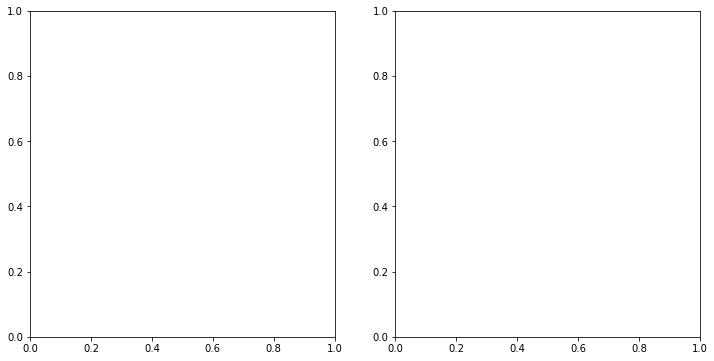

In [80]:
fig, axes = plt.subplots(1, 2,figsize=(12,6))
#df_train_t.plot(kind = "line", y = [".....","....."],ax=axes[0],title='Train');
#df_test_t.plot(kind = "line", y = [".....","......"],ax=axes[1],title='Test');
plt.show()

Calculamos la performance con RMSE.

In [81]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [82]:
#model_RMSE = RMSE(..... , .......)

In [83]:
#df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
#df_Results.loc[0, "Model"] = "LinearTrend"
#df_Results.loc[0, "RMSE"] = model_RMSE
#df_Results.head()

### Solución

---

### Ejercicio

----

A partir del dataset de ventas, seleccionar la categoría de Tecnología y

- Generar la serie de tiempo sobre las ventas y graficarla.
- Graficar los componentes de la serie.
- Generar un modelo de Tendencia lineal y validarlo. 

### Ejercicio

----
A partir del dataset filtrado por Tecnología, generamos la serie de tiempo y la graficamos.

In [84]:
df = pd.read_excel("../Data/Supertienda.xls")
tecno = df.loc[df['Categoria'] == 'Tecnología']

In [85]:
tecno.head(2)

,ID,ID_pedido,Fecha_pedido,Fecha_envio,Forma_envio,ID_cliente,Nombre_cliente,Segmento,Ciudad,Estado,Pais,Region,ID_producto,Categoria,Subcategoria,Nombre_producto,Ventas,Cantidad,Descuento,Ganancia
11,3500,MX-2020-166443,2020-08-21,2020-08-25,Estándar,WV-21820,Wendi Valdés,Cliente,Maceió,Alagoas,Brasil,Sur,TEC-MÁ-10004980,Tecnología,Máquinas,"Panasonic Impresora, Rojo",7030.4,4,0.0,3515.2
23,8066,MX-2021-113586,2021-11-18,2021-11-18,Mismo día,FF-14890,Fidel Ferrer,Empresa,Maceió,Alagoas,Brasil,Sur,TEC-TE-10002678,Tecnología,Teléfonos,"Apple Base de audio, Tamaño completo",4484.8,4,0.0,492.8


In [86]:
tecnogb = tecno.groupby('Fecha_pedido')['Ventas'].sum().reset_index()
tecnogb = tecnogb.set_index('Fecha_pedido')

In [87]:
df_ventas_t = tecnogb['Ventas'].resample('MS').mean().to_frame(); 
df_ventas_t.head(2)

,Ventas
Fecha_pedido,
2018-01-01,5248.57776
2018-02-01,5843.67508


Graficamos la serie.

<Figure size 288x216 with 0 Axes>

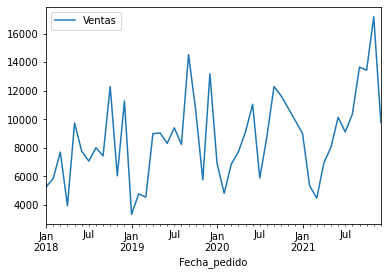

In [88]:
plt.figure(figsize=(4,3)); df_ventas_t.plot(); plt.show()

### Ejercicio

----
Graficamos los componentes de la serie de tiempo (Tendencia, Estacionalidad y la Componente aleatoria).

<Figure size 1152x720 with 0 Axes>

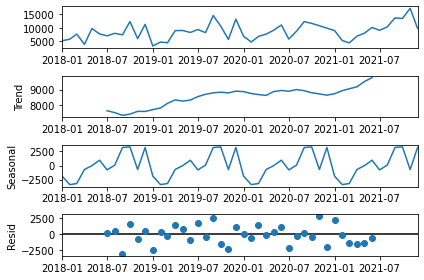

In [89]:
import statsmodels.api as sm
plt.figure(figsize=(16,10))
decomposition = sm.tsa.seasonal_decompose(df_ventas_t, model='additive')
decomposition.plot()
plt.show()

### Ejercicio

----
Generamos el modelo de Tendencia Lineal: lo ajustamos sobre train, creamos las predicciones, las graficamos sobre train y test, y evaluamos el modelo con RMSE.

Previamente definimos la variable “dummy de tiempo”, la secuencia que representa al tiempo.

In [90]:
df_ventas_t["timeIndex"] = pd.Series(np.arange(len(df_ventas_t['Ventas'])), index=df_ventas_t.index)
df_ventas_t.timeIndex.head(3)

Fecha_pedido
2018-01-01    0
2018-02-01    1
2018-03-01    2
Freq: MS, Name: timeIndex, dtype: int32

Hacemos los datasets de train y test. Recordar que tenemos que usar `shuffle=False`.

In [91]:
from sklearn.model_selection import train_test_split
df_train_t, df_test_t = train_test_split(df_ventas_t, test_size=12, random_state=42, shuffle=False)

Creamos un modelo de *regresión lineal* entre "Ventas" y "timeIndex". 

In [92]:
import statsmodels.formula.api as smf
model_linear = smf.ols(formula='Ventas ~ timeIndex', data = df_train_t).fit()

Generamos las predicciones del modelo sobre *train y test*.

In [93]:
df_train_t["LinearTrend"] = model_linear.predict(df_train_t.timeIndex)
df_test_t["LinearTrend"] = model_linear.predict(df_test_t.timeIndex)

Chequeamos visualmente las predicciones. 

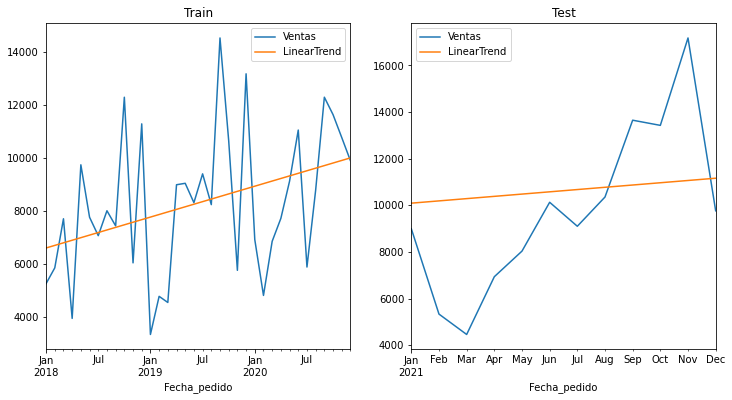

In [94]:
fig, axes = plt.subplots(1, 2,figsize=(12,6))
df_train_t.plot(kind = "line", y = ["Ventas","LinearTrend"],ax=axes[0],title='Train');
df_test_t.plot(kind = "line", y = ["Ventas","LinearTrend"],ax=axes[1],title='Test');
plt.show()

Calculamos la performance con RMSE.

In [95]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [96]:
model_RMSE = RMSE(df_test_t.LinearTrend, df_test_t.Ventas)
print('Evaluacion RMSE: ',model_RMSE)

Evaluacion RMSE:  3322.0132329163553


<div class="div-dhds-fondo-1"> Referencias y Material Adicional
<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M3/CLASE_21_Regresion_Lineal_Simple/Presentacion/img/M3_CLASE_21_separador.png" align="center" />

</div>

### Referencias y Material Adicional

---

<a href="https://www.statsmodels.org/stable/index.html" target="_blank">statmodels</a>

<a href="https://pandas.pydata.org/pandas-docs/version/0.23/timeseries.html" target="_blank">Pandas - Time Series / Date functionality</a>

<a href="https://konstantin-rink.medium.com/your-comprehensive-guide-to-the-basics-of-time-series-modeling-f673398b5df3" target="_blank">Your comprehensive guide to the basics of Time Series Modeling</a>

<a href="https://otexts.com/fpp2/" target="_blank">Forecasting: Principles and Practice</a>

<a href="https://towardsdatascience.com/pandas-resample-tricks-you-should-know-for-manipulating-time-series-data-7e9643a7e7f3" target="_blank">Pandas resample() tricks you should know for manipulating time-series data</a>

<a href="https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788" target="_blank">Time Series in Python — Exponential Smoothing and ARIMA processes</a>

<a href="https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/" target="_blank">Time Series Forecasting Methods</a>

<a href="https://towardsdatascience.com/moving-averages-in-python-16170e20f6c" target="_blank">Moving averages with Python</a>